In [1]:
# imports
import os
import numpy as np
import cv2
from glob import glob
import pydicom as dicom
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import skops.io as sio
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.preprocessing import LabelEncoder, StandardScaler

2024-05-17 13:36:38.742399: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 13:36:38.764263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 13:36:38.764287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 13:36:38.764949: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 13:36:38.769390: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#seeding
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
folders= glob('filtered_images/*')

(-0.5, 887.5, 732.5, -0.5)

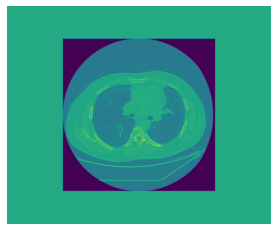

In [4]:
# Specify your image path
image_path = glob(folders[0] + '/*.dcm')[0]
# image_path = folders[0]

ds = dicom.dcmread(image_path)
plt.imshow(ds.pixel_array)
plt.axis('off')

In [5]:
def imgtoarr(path):
    ds = dicom.dcmread(path)
    img = ds.pixel_array
    img = cv2.resize(img, (128, 128))
    img_array = np.expand_dims(img, axis=0)
    return img_array

In [6]:
train_data = pd.read_csv('train.csv')
data = pd.DataFrame()
image_pixels = []
fvc_values = []
encoder_sex = LabelEncoder()
encoder_smoking = LabelEncoder()
train_data['Sex'] = encoder_sex.fit_transform(train_data['Sex'])
train_data['SmokingStatus'] = encoder_smoking.fit_transform(train_data['SmokingStatus'])
train_data['Percent'] = train_data['Percent']/100

for patient_folder in folders:
    try:
        images = glob(patient_folder + '/*')
        for image in images:
            img = imgtoarr(image)
            image_pixels.append(img)

        patient_id = patient_folder.split('/')[1]
        patient_data = train_data[train_data['Patient']==patient_id]
        patient_data = patient_data.drop(['Patient', 'FVC'], axis=1)
        patient_week = 0
        patient_perc = patient_data['Percent'].mean()
        patient_age = patient_data['Age'].mean()
        patient_sex = patient_data['Sex'].mean()
        patient_smoking = patient_data['SmokingStatus'].mean()
        patient_perc = patient_perc/100
        model = sio.load("xgb.skops", trusted=True)
        week0_fvc = model.predict([[patient_week, patient_perc, patient_age, patient_sex, patient_smoking]])
        fvc_values.extend([week0_fvc]*11)
    except RuntimeError:
            continue
    
data['image'] = image_pixels
data['FVC'] = fvc_values

In [7]:
batch_size = 64
model = models.Sequential()
model.add(layers.Input(shape=(batch_size, 128,128, 1)))
model.add(layers.Conv2D(64, kernel_size=(3,3)))
model.add(layers.Conv2D(128, kernel_size=(3,3)))
model.add(layers.Conv2D(128, kernel_size=(3,3)))
model.add(layers.Conv2D(128, kernel_size=(3,3)))
model.add(layers.Conv2D(64, kernel_size=(3,3)))
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss='mean_squared_error')

2024-05-17 13:36:47.072395: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 13:36:47.095062: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 13:36:47.095211: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
data['FVC'] = data['FVC'].apply(lambda x: x[0])